# Introduction

Author: Nishant Nayar

# RMS Titanic

***RMS Titanic*** was a British passenger liner, operated by the White Star Line, which sank in the North Atlantic Ocean on 15 April 1912 after striking an iceberg during her maiden voyage from Southampton, UK, to New York City. Of the estimated 2,224 passengers and crew aboard, more than 1,500 died, which made the sinking possibly one of the deadliest for a single ship up to that time.It remains to this day the deadliest peacetime sinking of a superliner or cruise ship. The disaster drew much public attention, provided foundational material for the disaster film genre, and has inspired many artistic works.

## Background

Titanic example is the first project that every data enthusiast starts with. There are many articles and topics that talk about the underlying statistics and data science concepts. This is an effort to make this project understandable for all those who are not versed in statistics and concepts of data science. The emphasis here is to make the machine learning models explainable to all.

# Loading Libraries

In [1]:
# linear algebra
import numpy as np

# data processing
import pandas as pd
import re

# fancy tables
import qgrid
from termcolor import colored
import dataframe_image as dfi

# data visualization
import seaborn as sns

# suppressing pesky warnings
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

# Algorithms
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn import datasets
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

from dtreeplt import dtreeplt

import optuna
from sklearn import ensemble
from sklearn import datasets
from sklearn import model_selection

In [2]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)

#Setting colors
enmax_palette = ["#FFD966", "#434343" , "#fff2cc", '#fafafa', '#E63A00', '#FF8D67', '#1AFF54', '#B3FFC6', '#A6A6A6']
color_codes_wanted = ['cream', 'black', 'lightcream', 'lightblue', 'red', 'lightred', 'green', 'lightgreen', 'grey']

c = lambda x: enmax_palette[color_codes_wanted.index(x)]

# Exploratory Data Analysis

## Loading Data

We will be first loading the data from Kaggle competiton website. 

In [3]:
test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")

In [4]:
train = int(round(len(train_df) / (len(train_df) + len(test_df)), 2) * 100)
test = int(round(len(test_df) / (len(train_df) + len(test_df)), 2) * 100)
print (colored(("The train to test ratio is {0}:{1}".format(train, test)), 'red', attrs=['bold']))

The train to test ratio is 68:32


## Data Elements

### Age and Sex

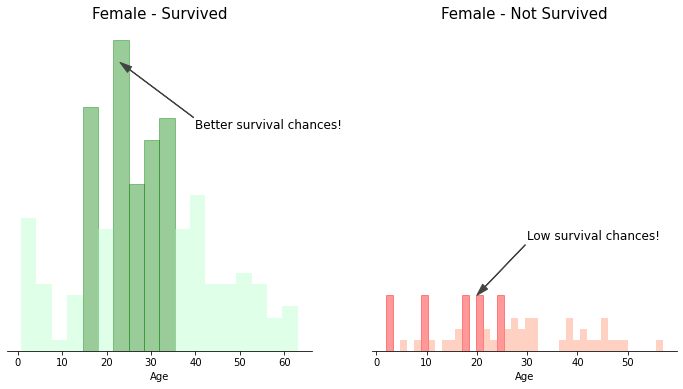

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 6), sharey=True)
survived = 'survived'
not_survived = 'not survived'
women = train_df[train_df['Sex']=='female']
ax=sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, 
                label = survived,
                kde=False, color=c("lightgreen"),  ax = axes[0])
heights = [p.get_height() for p in ax.patches]
highest = sorted(heights)[-5]
for p in ax.patches:
    if  p.get_height() >= highest:
        p.set_color("green")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.set_yticks([])
ax.annotate('Better survival chances!', xy=(23, 26), xytext=(40, 20), 
            fontsize=12, arrowprops={'width':0.4,'headwidth':7,'color':'#434343'})
ax.set_title('Female - Survived',fontsize=15)
ax=sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label = not_survived,kde=False, 
                color=c("lightred"), ax = axes[1])
heights = [p.get_height() for p in ax.patches]
highest = sorted(heights)[-5]
for p in ax.patches:
    if  p.get_height() >= highest:
        p.set_color("red")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.set_yticks([])
ax.annotate('Low survival chances!', xy=(20, 5), xytext=(30, 10), 
            fontsize=12, arrowprops={'width':0.4,'headwidth':7,'color':'#434343'})
_ = ax.set_title('Female - Not Survived', fontsize=15)
fig.savefig('./img/FemaleSurvival.png', transparent=True)

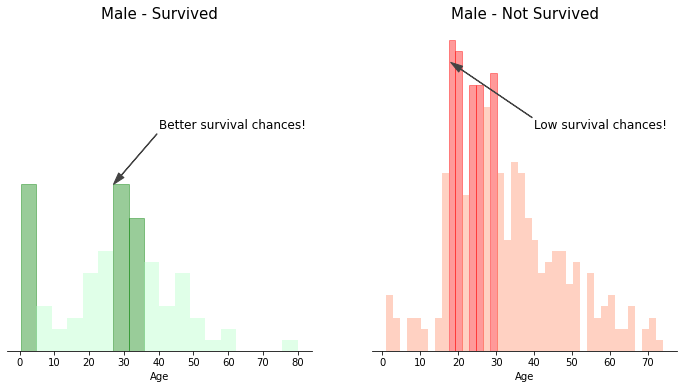

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 6), sharey=True)
survived = 'survived'
not_survived = 'not survived'
men = train_df[train_df['Sex']=='male']
ax=sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, 
                label = survived,
                kde=False, color=c("lightgreen"),  ax = axes[0])
heights = [p.get_height() for p in ax.patches]
third_highest = sorted(heights)[-3]
for p in ax.patches:
    if  p.get_height() >= third_highest:
        p.set_color("green")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.set_yticks([])
ax.annotate('Better survival chances!', xy=(27, 15), xytext=(40, 20), 
            fontsize=12, 
            arrowprops={'width':0.4,'headwidth':7,'color':'#434343'})
ax.set_title('Male - Survived', fontsize=15)
ax=sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, 
                label = not_survived,
                kde=False, 
                color=c("lightred"), ax = axes[1])
heights = [p.get_height() for p in ax.patches]
third_highest = sorted(heights)[-5]
for p in ax.patches:
    if  p.get_height() >= third_highest:
        p.set_color("red")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.set_yticks([])
ax.annotate('Low survival chances!', xy=(18, 26), xytext=(40, 20), 
            fontsize=12, 
            arrowprops={'width':0.4,'headwidth':7,'color':'#434343'})
_ = ax.set_title('Male - Not Survived', fontsize=15)
fig.savefig('./img/MaleSurvival.png', transparent=True)

### Embarked

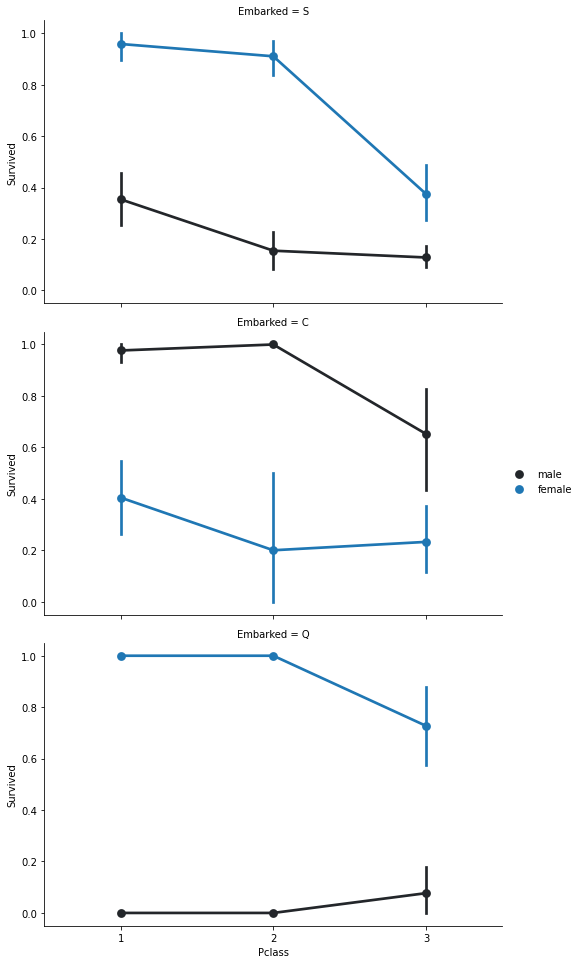

In [7]:
FacetGrid = sns.FacetGrid(train_df, row='Embarked', size=4.5, aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette=None,  order=None, hue_order=None )
FacetGrid.add_legend()

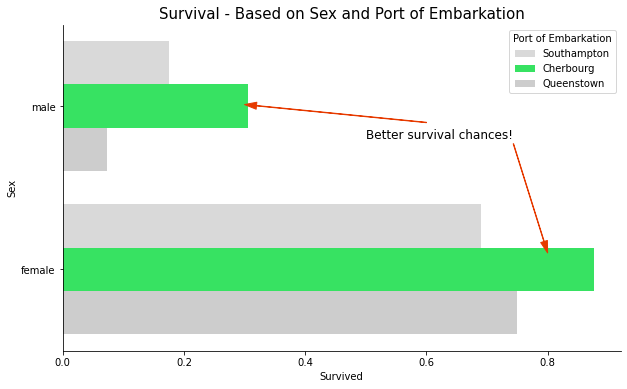

In [8]:
#palette = sns.color_palette("Blues")
#palette.reverse()
colors = ['#D9D9D9', '#1AFF54', '#CDCDCD' ]
sns.set_palette(sns.color_palette(colors))
fig, axes = plt.subplots(figsize=(10, 6))
ax=sns.barplot(x='Survived', 
            y='Sex', 
            hue = 'Embarked',
            data=train_df,
              ci=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.annotate('Better survival chances!', xy=(0.8, 0.9), xytext=(0.5, 0.2), 
            fontsize=12, 
            arrowprops={'width':0.4,'headwidth':7,'color':'#E63A00'})
ax.annotate('',xy=(0.3, -0.01), xytext=(0.6, 0.1), 
                        arrowprops={'width':0.4,'headwidth':7,'color':'#E63A00'})
ax.set_title('Survival - Based on Sex and Port of Embarkation', fontsize=15)
legend_labels, _= ax.get_legend_handles_labels()
ax.legend(legend_labels, ['Southampton','Cherbourg','Queenstown'],title='Port of Embarkation')
fig.savefig('./img/Embarkation.png', transparent=True)

### Pclass

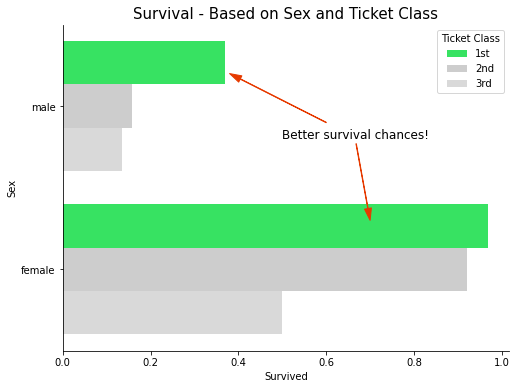

In [9]:
#palette = sns.color_palette("Blues")
#palette.reverse()
colors = ['#1AFF54',  '#CDCDCD', '#D9D9D9']
sns.set_palette(sns.color_palette(colors))
fig, axes = plt.subplots(figsize=(8, 6))
ax=sns.barplot(x='Survived', 
            y='Sex', 
            hue = 'Pclass',
            data=train_df,
              ci=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.annotate('Better survival chances!', xy=(0.7, 0.7), xytext=(0.5, 0.2), 
            fontsize=12, 
            arrowprops={'width':0.4,'headwidth':7,'color':'#E63A00'})
ax.annotate('',xy=(0.38, -0.2), xytext=(0.6, 0.1), 
                        arrowprops={'width':0.4,'headwidth':7,'color':'#E63A00'})
ax.set_title('Survival - Based on Sex and Ticket Class', fontsize=15)
legend_labels, _= ax.get_legend_handles_labels()
ax.legend(legend_labels, ['1st','2nd','3rd'],title='Ticket Class')
fig.savefig('./img/Sex-Ticket.png', transparent=True)

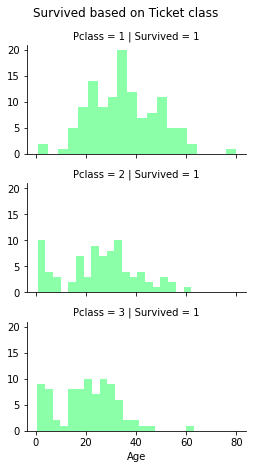

In [10]:
grid = sns.FacetGrid(train_df[train_df['Survived']==1], col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20, color=c("green"))
grid.add_legend();
grid.fig.subplots_adjust(top=0.9)
grid.fig.suptitle('Survived based on Ticket class')
fig.savefig('./img/survivedfactegrid.png', transparent=True)

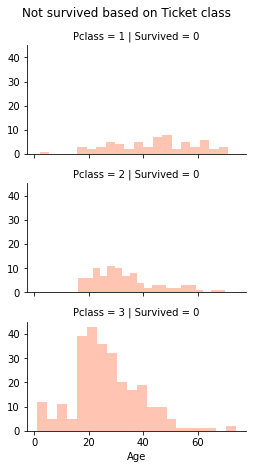

In [11]:
grid = sns.FacetGrid(train_df[train_df['Survived']==0], col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20, color=c("lightred"))
grid.add_legend();
grid.fig.subplots_adjust(top=0.9)
grid.fig.suptitle('Not survived based on Ticket class')
fig.savefig('./img/notsurvivedfactegrid.png', transparent=True)

### SibSp and Parch

In [12]:
data = [train_df, test_df]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
    dataset['not_alone'] = dataset['not_alone'].astype(int)
train_df['not_alone'].value_counts()

1    537
0    354
Name: not_alone, dtype: int64

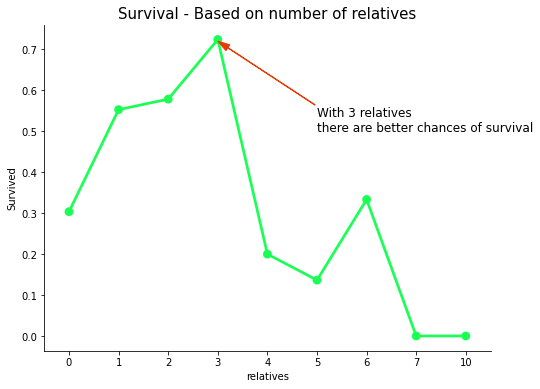

In [13]:
fig, axes = plt.subplots(figsize=(8, 6))
ax = sns.pointplot('relatives','Survived', data=train_df, aspect = 2.5, ci=0, color=c("green"))
ax.annotate('With 3 relatives \nthere are better chances of survival', 
            xy=(3, 0.72), 
            xytext=(5,0.5), 
            fontsize=12, 
            arrowprops={'width':0.4,'headwidth':7,'color':'#E63A00'})   
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.set_title('Survival - Based on number of relatives', fontsize=15)
fig.savefig('./img/Relatives.png', transparent=True)

## Data Preprocessing

### Missing Data

### Train Data

In [14]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent_1 = train_df.isnull().sum() / train_df.isnull().count()
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data_train = pd.concat([total, percent_2], axis=1, keys=["Total", "Percentage"])
index_ = ['Cabin', 'Age', 'Port of Embarkation',  'Passenger Id', 'Survived', 'Ticket class', 'Name', 'Sex', 
          'Siblings / Spouses', 'Parents / Children', 'Ticket Number', 'Fare','Relatives', 'Alone']
missing_data_train.index = index_
format_dict = { "Percentage": "{:.0%}",}
train_format=pd.DataFrame(missing_data_train).style.format(format_dict).bar(color='#E63A00', subset=['Total', 'Percentage'])
train_format

,Total,Percentage
Cabin,687,80%
Age,177,20%
Port of Embarkation,2,0%
Passenger Id,0,0%
Survived,0,0%
Ticket class,0,0%
Name,0,0%
Sex,0,0%
Siblings / Spouses,0,0%
Parents / Children,0,0%


In [15]:
dfi.export(train_format, './img/train_data.png')

In [16]:
# Quick check to see data columns
total = test_df.isnull().sum().sort_values(ascending=False)
percent_1 = test_df.isnull().sum() / test_df.isnull().count()
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data_test = pd.concat([total, percent_2], axis=1, keys=["Total", "Percentage"])
index_ = ['Cabin', 'Age', 'Fare', 'Passenger Id', 'Ticket class', 'Name', 'Sex', 
          'Siblings / Spouses', 'Parents / Children', 'Ticket Number', 
          'Port of Embarkation', 'Relatives', 'Alone']
missing_data_test.index = index_
format_dict = { "Percentage": "{:.0%}",}
test_format=pd.DataFrame(missing_data_test).style.format(format_dict).bar(color='#E63A00', subset=['Total', 'Percentage'])
test_format

,Total,Percentage
Cabin,327,80%
Age,86,20%
Fare,1,0%
Passenger Id,0,0%
Ticket class,0,0%
Name,0,0%
Sex,0,0%
Siblings / Spouses,0,0%
Parents / Children,0,0%
Ticket Number,0,0%


In [17]:
dfi.export(test_format, './img/test_data.png')

### Dropping Columns

In [18]:
train_df = train_df.drop(['PassengerId'], axis=1)

#### Cabin

In [19]:
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [train_df, test_df]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)
# we can now drop the cabin feature
train_df = train_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)

#### Age

In [20]:
data = [train_df, test_df]

for dataset in data:
    mean = train_df["Age"].mean()
    std = test_df["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = train_df["Age"].astype(int)
train_df["Age"].isnull().sum()

0

#### Embarked

In [21]:
train_df['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [22]:
common_value = 'S'
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)

In [23]:
ports = {"S": 0, "C": 1, "Q": 2}
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

### Converting Feature

#### Fare

In [24]:
data = [train_df, test_df]

for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)

#### Name

In [25]:
data = [train_df, test_df]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    # extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace titles with a more common title or as Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # convert titles into numbers
    dataset['Title'] = dataset['Title'].map(titles)
    # filling NaN with 0, to get safe
    dataset['Title'] = dataset['Title'].fillna(0)
train_df = train_df.drop(['Name'], axis=1)
test_df = test_df.drop(['Name'], axis=1)

#### Sex

In [26]:
genders = {"male": 0, "female": 1}
data = [train_df, test_df]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

#### Ticket

In [27]:
train_df = train_df.drop(['Ticket'], axis=1)
test_df = test_df.drop(['Ticket'], axis=1)

### Creating Categories

#### Age

In [28]:
data = [train_df, test_df]
for dataset in data:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 6

#### Fare

In [29]:
data = [train_df, test_df]

for dataset in data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 250, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)

### Creating New Categories

#### Age time Class

In [30]:
data = [train_df, test_df]
for dataset in data:
    dataset['Age_Class']= dataset['Age']* dataset['Pclass']

#### Fare per person

In [31]:
for dataset in data:
    dataset['Fare_Per_Person'] = dataset['Fare']/(dataset['relatives']+1)
    dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)

# Feature Selection

In [32]:
train_df.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'relatives', 'not_alone', 'Deck', 'Title', 'Age_Class', 'Fare_Per_Person'], dtype='object')

|Column Name|Category|Comments|
|---:|:---|:---|
|Survived|Categorcal|**Target Variable**|
|Pclass|Categorical|Keep|
|Sex|Categorical|Keep
|Age|Continuous|Keep|
|SibSp|Categorical|Keep|
|Parch|Categorical|Keep|
|Fare|Continuous|Keep|
|Embarked|Categorical|Keep|
|relatives|Continuous|Keep|
|not_alone|Categorical|Keep|
|Deck|Categorical|Keep|
|Title|Categorical|Keep||
|Age_Class|Continuous|Keep|
|Fare_Per_Person|Continuous|Keep|

|Predictor|Target|Test|Comment|
|---:|:---|:---:|:---:|
|Continuous|Continuous|Correlation Matrix|*Not Applicable for this project*|
|Continuous|Categorical|ANOVA Test|Applicable|
|Categorical|Categorical|Chi-Square test|Applicable|

## ANOVA Test

In [33]:
# Defining a function to find the statistical relationship with all the categorical variables
def FunctionAnova(inpData, TargetVariable, ContinuousPredictorList):
    from scipy.stats import f_oneway

    # Creating an empty list of final selected predictors
    SelectedPredictors=[]
    DroppedPredictors=[]
    
    print('##### ANOVA Results ##### \n')
    for predictor in ContinuousPredictorList:
        CategoryGroupLists=inpData.groupby(TargetVariable)[predictor].apply(list)
        AnovaResults = f_oneway(*CategoryGroupLists)
        
        # If the ANOVA P-Value is <0.05, that means we reject H0
        if (AnovaResults[1] < 0.05):
            print(predictor, 'is correlated with', TargetVariable, '| P-Value:', AnovaResults[1])
            SelectedPredictors.append(predictor)
        else:
            print(predictor, 'is NOT correlated with', TargetVariable, '| P-Value:', AnovaResults[1])
            DroppedPredictors.append(predictor)
    
    return(DroppedPredictors)
    

ContinuousVariables=['Age','Fare', 'relatives', 'Age_Class', 'Fare_Per_Person']
drop=FunctionAnova(inpData=train_df, TargetVariable='Survived', ContinuousPredictorList=ContinuousVariables)

##### ANOVA Results ##### 

Age is correlated with Survived | P-Value: 0.04598562648084481
Fare is correlated with Survived | P-Value: 1.3332563723606031e-21
relatives is NOT correlated with Survived | P-Value: 0.6198911221344969
Age_Class is correlated with Survived | P-Value: 6.015170499655656e-18
Fare_Per_Person is correlated with Survived | P-Value: 1.3885779860101231e-08


In [34]:
for predictor in drop:
    train_df.drop([predictor], axis = 1, inplace=True)
    print(predictor, 'is dropped from Train Df')
    test_df.drop([predictor], axis = 1, inplace=True)
    print(predictor, 'is dropped from Test Df')

relatives is dropped from Train Df
relatives is dropped from Test Df


## ChiSq

In [35]:
# Writing a function to find the correlation of all categorical variables with the Target variable
def FunctionChisq(inpData, TargetVariable, CategoricalVariablesList):
    from scipy.stats import chi2_contingency
    
    # Creating an empty list of final selected predictors
    SelectedPredictors=[]
    DroppedPredictors=[]

    for predictor in CategoricalVariablesList:
        CrossTabResult=pd.crosstab(index=inpData[TargetVariable], columns=inpData[predictor])
        ChiSqResult = chi2_contingency(CrossTabResult)
        
        # If the ChiSq P-Value is <0.05, that means we reject H0
        if (ChiSqResult[1] < 0.05):
            print(predictor, 'is correlated with', TargetVariable, '| P-Value:', ChiSqResult[1])
            SelectedPredictors.append(predictor)
        else:
            print(predictor, 'is NOT correlated with', TargetVariable, '| P-Value:', ChiSqResult[1])
            DroppedPredictors.append()
            
    return(DroppedPredictors)

In [36]:
CategoricalVariables=['Pclass', 'Sex',  'SibSp', 'Parch',  'Embarked',  'not_alone', 'Deck', 'Title',  ]

# Calling the function
drop = FunctionChisq(inpData=train_df, TargetVariable='Survived', CategoricalVariablesList= CategoricalVariables)

Pclass is correlated with Survived | P-Value: 4.549251711298793e-23
Sex is correlated with Survived | P-Value: 1.1973570627755645e-58
SibSp is correlated with Survived | P-Value: 1.5585810465902116e-06
Parch is correlated with Survived | P-Value: 9.703526421039997e-05
Embarked is correlated with Survived | P-Value: 2.300862648144953e-06
not_alone is correlated with Survived | P-Value: 1.9726543846517183e-09
Deck is correlated with Survived | P-Value: 6.326020042314704e-18
Title is correlated with Survived | P-Value: 3.957861347159744e-61


In [37]:
for predictor in drop:
    train_df.drop([predictor], axis = 1, inplace=True)
    print(predictor, 'is dropped from Train Df')
    test_df.drop([predictor], axis = 1, inplace=True)
    print(predictor, 'is dropped from Test Df')

In [38]:
# Extracting the target variable
y = train_df['Survived']

# Removing the interest column
X = train_df.drop(['Survived'], axis = 1)
Predictors=X.columns
Target='Survived'

### Sandardization of data ###
PredictorScaler=MinMaxScaler()

# Storing the fit object for later reference
PredictorScalerFit=PredictorScaler.fit(X)

# Generating the standardized values of X
X=PredictorScalerFit.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [39]:
# Sanity check for the sampled data
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(712, 12)
(712,)
(179, 12)
(179,)


# Model Building

## Logistic Regression

In [40]:
clf = LogisticRegression(C=5,penalty='l2', solver='newton-cg')

In [41]:
# Creating the model on Training Data
LOG=clf.fit(X_train,y_train)
prediction=LOG.predict(X_test)

In [42]:
print(metrics.classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83       109
           1       0.76      0.63      0.69        70

    accuracy                           0.78       179
   macro avg       0.77      0.75      0.76       179
weighted avg       0.77      0.78      0.77       179



In [43]:
# Printing the Overall Accuracy of the model
F1_Score_LOGR=round((metrics.f1_score(y_test, prediction, average='weighted')*100),2)
#print('Accuracy of the model on Testing Sample Data:', F1_Score_LOGR)
ACC_LOGR = round((LOG.score(X_train, y_train)*100), 2)

In [44]:
# Running 10-Fold Cross validation on a given algorithm
# Passing full data X and y because the K-fold will split the data and automatically choose train/test
Accuracy_Values=cross_val_score(LOG, X , y, cv=10, scoring='f1_weighted')
#print('\nAccuracy values for 10-fold Cross Validation:\n',Accuracy_Values)
#print('\nFinal Average Accuracy of the model:', round(Accuracy_Values.mean(),2))
F1_Score_LOGR_CV = round((Accuracy_Values.mean()*100),2)

Accuracy_Values=cross_val_score(LOG, X , y, cv=10, scoring='accuracy')
#print('\nAccuracy values for 10-fold Cross Validation:\n',Accuracy_Values)
#print('\nFinal Average Accuracy of the model:', round(Accuracy_Values.mean(),2))
ACC_LOGR_CV = round((Accuracy_Values.mean()*100),2)

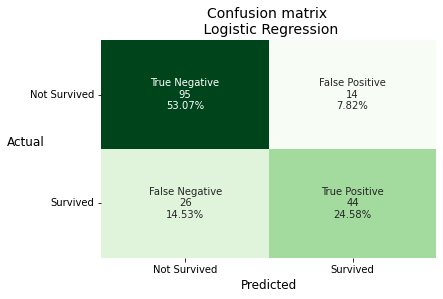

In [45]:
# Calculate Matrix
cf_matrix=metrics.confusion_matrix(y_test, prediction)

# Build Correlation matrix
group_names = ['True Negative','False Positive','False Negative','True Positive']
ticks =['Not Survived', 'Survived']
group_counts = ["{0:0.0f}".format(value) for value in  cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax=sns.heatmap(cf_matrix, annot=labels, fmt='', cmap="Greens", cbar=False)
plt.yticks(plt.yticks()[0], labels=ticks, rotation=0)
plt.xticks(plt.xticks()[0], labels=ticks)
plt.title("Confusion matrix \n Logistic Regression", fontsize=14)
plt.ylabel("Actual", rotation=0, fontsize=12)
plt.xlabel("Predicted", fontsize=12)
plt.show()

## Decision Trees

In [46]:
clf = tree.DecisionTreeClassifier(max_depth=3,criterion='entropy')

# Creating the model on Training Data
DTree=clf.fit(X_train,y_train)
prediction=DTree.predict(X_test)

In [47]:
# F1 score
F1_Score_DT=round((metrics.f1_score(y_test, prediction, average='weighted')*100),2)
ACC_DT = round((LOG.score(X_train, y_train)*100), 2)

In [48]:
Accuracy_Values=cross_val_score(DTree, X , y, cv=10, scoring='f1_weighted')
F1_Score_DT_CV = round((Accuracy_Values.mean()*100),2)
Accuracy_Values=cross_val_score(DTree, X , y, cv=10, scoring='accuracy')
ACC_DT_CV = round((Accuracy_Values.mean()*100),2)

<AxesSubplot:>

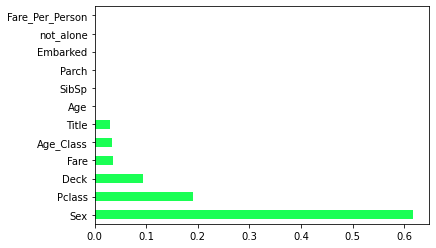

In [49]:
# Plotting the feature importance for Top 10 most important columns
# Fix this chart - Nishant
%matplotlib inline
feature_importances = pd.Series(DTree.feature_importances_, index=Predictors)
feature_importances.sort_values(ascending=False).plot(kind='barh')

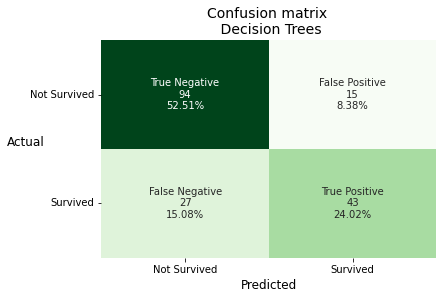

In [50]:
# Calculate Matrix
cf_matrix=metrics.confusion_matrix(y_test, prediction)

# Build Correlation matrix
group_names = ['True Negative','False Positive','False Negative','True Positive']
ticks =['Not Survived', 'Survived']
group_counts = ["{0:0.0f}".format(value) for value in  cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax=sns.heatmap(cf_matrix, annot=labels, fmt='', cmap="Greens", cbar=False)
plt.yticks(plt.yticks()[0], labels=ticks, rotation=0)
plt.xticks(plt.xticks()[0], labels=ticks)
plt.title("Confusion matrix \n Decision Trees", fontsize=14)
plt.ylabel("Actual", rotation=0, fontsize=12)
plt.xlabel("Predicted", fontsize=12)
plt.show()

### Visualization

[Text(418.5, 380.52, 'Sex <= 0.5\nentropy = 0.959\nsamples = 712\nvalue = [440, 272]\nclass = S'),
 Text(209.25, 271.8, 'Deck <= 0.875\nentropy = 0.672\nsamples = 454\nvalue = [374, 80]\nclass = S'),
 Text(104.625, 163.07999999999998, 'Age_Class <= 0.028\nentropy = 0.976\nsamples = 88\nvalue = [52, 36]\nclass = S'),
 Text(52.3125, 54.360000000000014, 'entropy = 0.0\nsamples = 5\nvalue = [0, 5]\nclass = u'),
 Text(156.9375, 54.360000000000014, 'entropy = 0.953\nsamples = 83\nvalue = [52, 31]\nclass = S'),
 Text(313.875, 163.07999999999998, 'Title <= 0.375\nentropy = 0.53\nsamples = 366\nvalue = [322, 44]\nclass = S'),
 Text(261.5625, 54.360000000000014, 'entropy = 0.467\nsamples = 332\nvalue = [299, 33]\nclass = S'),
 Text(366.1875, 54.360000000000014, 'entropy = 0.908\nsamples = 34\nvalue = [23, 11]\nclass = S'),
 Text(627.75, 271.8, 'Pclass <= 0.75\nentropy = 0.82\nsamples = 258\nvalue = [66, 192]\nclass = u'),
 Text(523.125, 163.07999999999998, 'Age_Class <= 0.611\nentropy = 0.313\ns

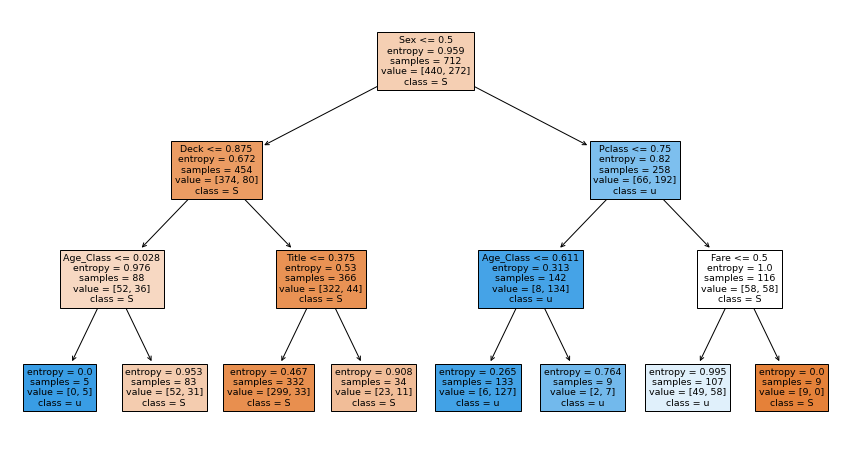

In [51]:
from sklearn.tree import plot_tree
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot()
plot_tree(clf, feature_names=Predictors, ax=ax, class_names=Target, filled=True)

## Random Forest

In [52]:
clf = RandomForestClassifier(max_depth=4, n_estimators=100,criterion='gini')
RF=clf.fit(X_train,y_train)
prediction=RF.predict(X_test)

In [53]:
# F1 score
F1_Score_RF=round((metrics.f1_score(y_test, prediction, average='weighted')*100),2)
ACC_RF = round((RF.score(X_train, y_train)*100), 2)

In [54]:
Accuracy_Values=cross_val_score(RF, X , y, cv=10, scoring='f1_weighted')
F1_Score_RF_CV = round((Accuracy_Values.mean()*100),2)
Accuracy_Values=cross_val_score(RF, X , y, cv=10, scoring='accuracy')
ACC_RF_CV = round((Accuracy_Values.mean()*100),2)

<AxesSubplot:>

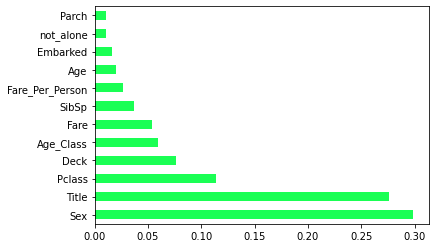

In [55]:
# Plotting the feature importance for Top 10 most important columns
# Fix this chart - Nishant
%matplotlib inline
feature_importances = pd.Series(RF.feature_importances_, index=Predictors)
feature_importances.sort_values(ascending=False).plot(kind='barh')

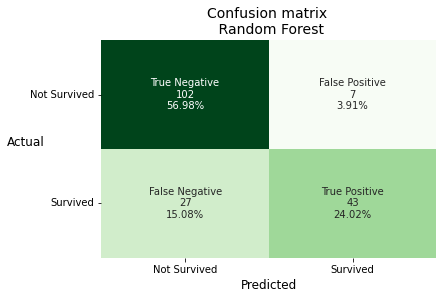

In [56]:
# Calculate Matrix
cf_matrix=metrics.confusion_matrix(y_test, prediction)

# Build Correlation matrix
group_names = ['True Negative','False Positive','False Negative','True Positive']
ticks =['Not Survived', 'Survived']
group_counts = ["{0:0.0f}".format(value) for value in  cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax=sns.heatmap(cf_matrix, annot=labels, fmt='', cmap="Greens", cbar=False)
plt.yticks(plt.yticks()[0], labels=ticks, rotation=0)
plt.xticks(plt.xticks()[0], labels=ticks)
plt.title("Confusion matrix \n Random Forest", fontsize=14)
plt.ylabel("Actual", rotation=0, fontsize=12)
plt.xlabel("Predicted", fontsize=12)
plt.show()

[Text(385.02, 391.392, 'Sex <= 0.5\ngini = 0.483\nsamples = 455\nvalue = [421, 291]\nclass = S'),
 Text(184.14, 304.416, 'Deck <= 0.875\ngini = 0.316\nsamples = 299\nvalue = [371, 91]\nclass = S'),
 Text(66.96, 217.44, 'Age <= 0.083\ngini = 0.481\nsamples = 65\nvalue = [58, 39]\nclass = S'),
 Text(33.48, 130.464, 'gini = 0.0\nsamples = 4\nvalue = [0, 8]\nclass = u'),
 Text(100.44, 130.464, 'Embarked <= 0.25\ngini = 0.454\nsamples = 61\nvalue = [58, 31]\nclass = S'),
 Text(66.96, 43.488, 'gini = 0.408\nsamples = 40\nvalue = [40, 16]\nclass = S'),
 Text(133.92, 43.488, 'gini = 0.496\nsamples = 21\nvalue = [18, 15]\nclass = S'),
 Text(301.32, 217.44, 'Age <= 0.083\ngini = 0.244\nsamples = 234\nvalue = [313, 52]\nclass = S'),
 Text(234.35999999999999, 130.464, 'Parch <= 0.25\ngini = 0.49\nsamples = 9\nvalue = [8, 6]\nclass = S'),
 Text(200.88, 43.488, 'gini = 0.32\nsamples = 7\nvalue = [8, 2]\nclass = S'),
 Text(267.84, 43.488, 'gini = 0.0\nsamples = 2\nvalue = [0, 4]\nclass = u'),
 Text(3

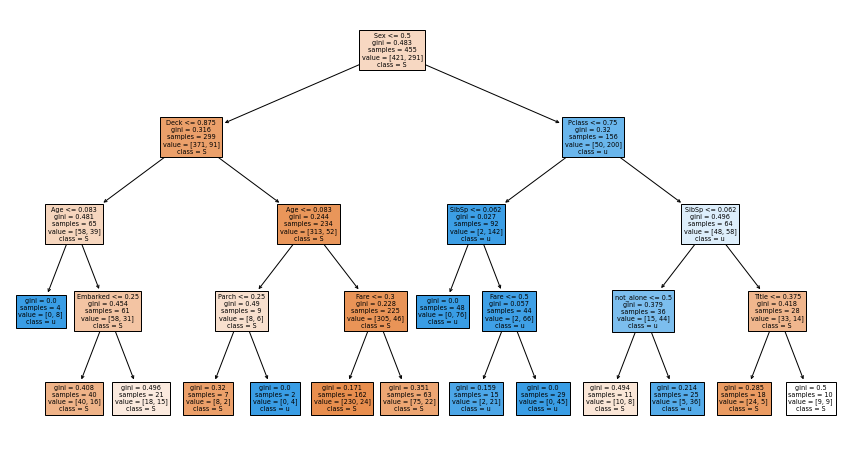

In [57]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot()
plot_tree(clf.estimators_[4], feature_names=Predictors, ax=ax, class_names=Target, filled=True)

## ADABoost

In [58]:
DTC=DecisionTreeClassifier(max_depth=3)
clf = AdaBoostClassifier(n_estimators=100, base_estimator=DTC ,learning_rate=0.1)

AB=clf.fit(X_train,y_train)
prediction=AB.predict(X_test)

In [59]:
# F1 score
F1_Score_AB=round((metrics.f1_score(y_test, prediction, average='weighted')*100),2)
ACC_AB = round((AB.score(X_train, y_train)*100), 2)

In [60]:
Accuracy_Values=cross_val_score(AB, X , y, cv=10, scoring='f1_weighted')
F1_Score_AB_CV = round((Accuracy_Values.mean()*100),2)
Accuracy_Values=cross_val_score(AB, X , y, cv=10, scoring='accuracy')
ACC_AB_CV = round((Accuracy_Values.mean()*100),2)

<AxesSubplot:>

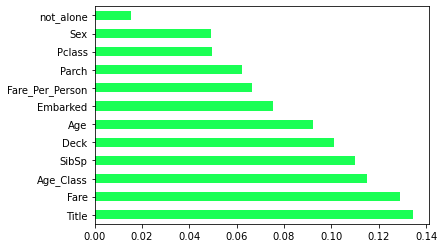

In [61]:
# Plotting the feature importance for Top 10 most important columns
# Fix this chart - Nishant
%matplotlib inline
feature_importances = pd.Series(AB.feature_importances_, index=Predictors)
feature_importances.sort_values(ascending=False).plot(kind='barh')

In [ ]:
# Calculate Matrix
cf_matrix=metrics.confusion_matrix(y_test, prediction)

# Build Correlation matrix
group_names = ['True Negative','False Positive','False Negative','True Positive']
ticks =['Not Survived', 'Survived']
group_counts = ["{0:0.0f}".format(value) for value in  cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax=sns.heatmap(cf_matrix, annot=labels, fmt='', cmap="Greens", cbar=False)
plt.yticks(plt.yticks()[0], labels=ticks, rotation=0)
plt.xticks(plt.xticks()[0], labels=ticks)
plt.title("Confusion matrix \n Random Forest", fontsize=14)
plt.ylabel("Actual", rotation=0, fontsize=12)
plt.xlabel("Predicted", fontsize=12)
plt.show()

In [ ]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot()
plot_tree(clf.estimators_[4], feature_names=Predictors, ax=ax, class_names=Target, filled=True)

## XGBoost

In [ ]:
clf=XGBClassifier(max_depth=2, learning_rate=0.1, n_estimators=200, objective='binary:logistic', booster='gbtree', eval_metric='logloss')

XGB=clf.fit(X_train,y_train)
prediction=XGB.predict(X_test)

In [ ]:
# F1 score
F1_Score_XGB=round((metrics.f1_score(y_test, prediction, average='weighted')*100),2)
ACC_XGB = round((XGB.score(X_train, y_train)*100), 2)

In [ ]:
Accuracy_Values=cross_val_score(XGB, X , y, cv=10, scoring='f1_weighted')
F1_Score_XGB_CV = round((Accuracy_Values.mean()*100),2)
Accuracy_Values=cross_val_score(XGB, X , y, cv=10, scoring='accuracy')
ACC_XGB_CV = round((Accuracy_Values.mean()*100),2)

In [ ]:
# Plotting the feature importance for Top 10 most important columns
# Fix this chart - Nishant
%matplotlib inline
feature_importances = pd.Series(XGB.feature_importances_, index=Predictors)
feature_importances.sort_values(ascending=False).plot(kind='barh')

## K Nearest Neighbor

In [ ]:
acc = []
for i in range(1,20):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train, y_train)
    Y_pred = knn.predict(X_test)
    acc_knn = round(knn.score(X_train, y_train) * 100, 2)
    acc.append(acc_knn)

acc_knn_df = pd.DataFrame({'k': range(1,20), 'Accuracy Score': acc })

In [ ]:
fig, axes = plt.subplots(figsize=(8, 6))
ax = sns.pointplot('k','Accuracy Score', data=acc_knn_df, aspect = 2.5, ci=0, color=c("green"))
ax.annotate('Highest Accuracy Score', xy=(100, 150), xytext=(70,15),  fontsize=12, 
            arrowprops={'width':0.4,'headwidth':7,'color':'#E63A00'})   
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.set_title('KNN - Accuracy Score', fontsize=15)
fig.savefig('./img/KNN-AccuracyScore.png', transparent=True)

In [ ]:
clf = KNeighborsClassifier(n_neighbors=(acc.index(max(acc))+1))
KNN=clf.fit(X_train,y_train)
prediction=KNN.predict(X_test)

In [ ]:
# F1 score
F1_Score_KNN=round((metrics.f1_score(y_test, prediction, average='weighted')*100),2)
ACC_KNN = round((KNN.score(X_train, y_train)*100), 2)

In [ ]:
Accuracy_Values=cross_val_score(KNN, X , y, cv=10, scoring='f1_weighted')
F1_Score_KNN_CV = round((Accuracy_Values.mean()*100),2)
Accuracy_Values=cross_val_score(KNN, X , y, cv=10, scoring='accuracy')
ACC_KNN_CV = round((Accuracy_Values.mean()*100),2)

In [ ]:
# Calculate Matrix
cf_matrix=metrics.confusion_matrix(y_test, prediction)

# Build Correlation matrix
group_names = ['True Negative','False Positive','False Negative','True Positive']
ticks =['Not Survived', 'Survived']
group_counts = ["{0:0.0f}".format(value) for value in  cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax=sns.heatmap(cf_matrix, annot=labels, fmt='', cmap="Greens", cbar=False)
plt.yticks(plt.yticks()[0], labels=ticks, rotation=0)
plt.xticks(plt.xticks()[0], labels=ticks)
plt.title("Confusion matrix \n Random Forest", fontsize=14)
plt.ylabel("Actual", rotation=0, fontsize=12)
plt.xlabel("Predicted", fontsize=12)
plt.show()

## Model Evaluation

In [ ]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Trees', 'Random Forest', 'ADABoost', 'XGBoost', 'K Nearest Neighbor'],
    'F1 Score': [F1_Score_LOGR,F1_Score_DT, F1_Score_RF,F1_Score_AB , F1_Score_XGB, F1_Score_KNN],
    'ACC Score': [ACC_LOGR, ACC_DT, ACC_RF, ACC_AB, ACC_XGB, ACC_KNN],
    'F1 Score Cross': [F1_Score_LOGR_CV, F1_Score_DT_CV,F1_Score_RF_CV, F1_Score_AB_CV, F1_Score_XGB_CV, F1_Score_KNN_CV],
    'ACC Score Cross': [ACC_LOGR_CV,ACC_DT_CV,ACC_RF_CV,ACC_AB_CV,ACC_XGB_CV, ACC_KNN_CV]
                        })
result_df = results.sort_values(by='F1 Score', ascending=False)
result_df = result_df.set_index('F1 Score')
result_df.head(9)